In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [4]:

def residual_mass(ux_matrix:np.ndarray,uy_matrix:np.ndarray):
    '''
    Compute the residual: mass conservation
    Formula: 
    Rs_mass = {d(ux)/dx + d(uy)/dy}^2.sum()/40000

    Arguments:
    ux_matrix: np.ndarray: matrix of x-velocity, shape = [200,200]
    uy_matrix: np.ndarray: matrix of y-velocity, shape = [200,200]

    Return:
    Rs_mass_sum: float: sum of Rs_mass
    '''
    assert ux_matrix.shape == (200,200), f"Shape is {ux_matrix.shape} but should be (200,200)"
    assert ux_matrix.shape == uy_matrix.shape, "Shape of ux_matrix and uy_matrix should be the same"
    ux_with_down_boundary = ux_matrix[2:200,1:199]
    ux_with_up_boundary = ux_matrix[0:198,1:199]
    uy_with_right_boundary = uy_matrix[1:199,2:200]
    uy_with_left_boundary = uy_matrix[1:199,0:198]

    pinn_dudx = (ux_with_down_boundary - ux_with_up_boundary)/(2*0.005)
    pinn_dvdy = (uy_with_right_boundary - uy_with_left_boundary)/(2*0.005)

    Rs_mass = pinn_dudx+pinn_dvdy
    Rs_mass_sq = Rs_mass*Rs_mass
    Rs_mass_sum = Rs_mass_sq.sum()/40000
    return Rs_mass_sum

def residual(pred_prev:np.ndarray, pred:np.ndarray,padded: bool=True):
    '''
    Compute the residual: mass conservation
    Arguments: 
    pred_prev: np.ndarray: prediction at time t-1, shape = [200,200,3(ux,uy,t)]
    pred: np.ndarray: prediction at time t, shape = [200,200,3(ux,uy,t)]
    '''
    if not padded: 
        raise NotImplementedError("Not implemented for non-padded case")
    
    ux_matrix = pred[:,:,0]
    uy_matrix = pred[:,:,1]
    Rs_mass_sum = residual_mass(ux_matrix,uy_matrix)
    return Rs_mass_sum

def residual_momentum(ux_matrix, ux_matrix_prev, uy_matrix, t_matrix):
    '''
    Compute the residual: momentum conservation
    Formula:
    Rs_mom = {d(ux)/dt + ux*d(ux)/dx + uy*d(ux)/dy - 1.831e-05/(348.33/alpha)*d^2(ux)/dx^2 - 9.81/293*(293-alpha)}^2.sum()/40000
    '''
    mom_1 = ux_matrix[1:199,1:199] - ux_matrix_prev[1:199,1:199]
    mom_3 = ux_matrix[1:199,1:199]*(ux_matrix[2:200,1:199] - ux_matrix[0:198,1:199])
    mom_4 = uy_matrix[1:199,1:199]*(ux_matrix[1:199,2:200] - ux_matrix[1:199,0:198])
    mom_5_2 = ux_matrix[1:199,2:200] - 2*ux_matrix[1:199,1:199] + ux_matrix[1:199,0:198] 
    mom_5 = 1.831e-05/(348.33/t_matrix[1:199,1:199])*(mom_5_2)
    mom_6 = 9.81/293*(293-t_matrix[1:199,1:199])

    Rs_mom = mom_1/0.01 +  mom_3/(2*0.005) + mom_4/(2*0.005) - mom_5/(0.005*0.005) - mom_6
    Rs_mom_sq = Rs_mom*Rs_mom
    Rs_mom_sum = Rs_mom_sq.sum()/40000
    return Rs_mom_sum

def residual_heat(ux_matrix:np.ndarray, uy_matrix:np.ndarray, t_matrix:np.ndarray, t_matrix_prev:np.ndarray):
    '''
    Compute the residual: heat conservation
    Formula:
    Rs_heat = {d(t)/dt + ux*d(t)/dx + uy*d(t)/dy - 0.14*(t-293)+21.7/1e6*d^2(t)/dx^2}^2.sum()/40000
    TODO: Check the formula

    Arguments:
    ux_matrix: np.ndarray: matrix of x-velocity, shape = [200,200]
    uy_matrix: np.ndarray: matrix of y-velocity, shape = [200,200]
    t_matrix: np.ndarray: matrix of temperature, shape = [200,200]
    t_matrix_prev: np.ndarray: matrix of temperature at previous time step, shape = [200,200]

    Return:
    Rs_heat_sum: float: sum of Rs_heat
    '''
    tdiff_matrix = (0.14*(t_matrix[1:199,1:199] - 293)+ 21.7)/1000000
    heat_1 = t_matrix[1:199,1:199] - t_matrix_prev[1:199,1:199]
    heat_2 = (t_matrix[2:200,1:199] - t_matrix[0:198,1:199])*(ux_matrix[1:199,1:199])
    heat_3 = (t_matrix[1:199,2:200] - t_matrix[1:199,0:198])*(uy_matrix[1:199,1:199])
    heat_4 = tdiff_matrix*(t_matrix[1:199,2:200] - 2*t_matrix[1:199,1:199] + t_matrix[1:199,0:198])

    Rs_heat = heat_1/0.01 + heat_2/(2*0.005) + heat_3/(2*0.005) - heat_4/(0.005*0.005)
    Rs_heat_sq = Rs_heat*Rs_heat
    Rs_heat_sum = Rs_heat_sq.sum()/40000
    return Rs_heat_sum

In [3]:
data_root = "../../dataset/"
t_arr = np.load(data_root + "t_arr.npy")
ux_arr = np.load(data_root + "ux_arr.npy")
uy_arr = np.load(data_root + "uy_arr.npy")

In [5]:
print(t_arr.shape, ux_arr.shape, uy_arr.shape)

(10000, 200, 200) (10000, 200, 200) (10000, 200, 200)


In [11]:
mass_arr = []
momentum_arr = []
heat_arr = []
for i in range(900, 1000):
    Rs_mass_sum = residual_mass(ux_arr[i], uy_arr[i])
    Rs_momentum_sum = residual_momentum(ux_arr[i], ux_arr[i-1], uy_arr[i], t_arr[i])
    Rs_heat_sum = residual_heat(ux_arr[i], uy_arr[i], t_arr[i], t_arr[i-1])
    mass_arr.append(Rs_mass_sum)
    momentum_arr.append(Rs_momentum_sum)
    heat_arr.append(Rs_heat_sum)

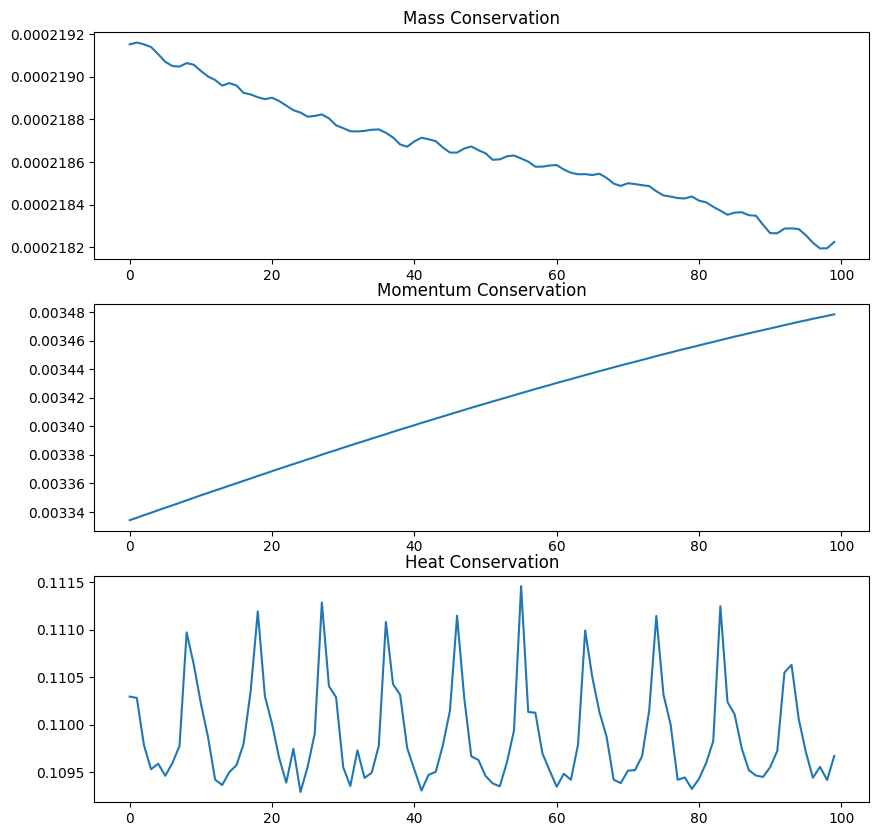

In [12]:
fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(mass_arr)
ax[0].set_title("Mass Conservation")
ax[1].plot(momentum_arr)
ax[1].set_title("Momentum Conservation")
ax[2].plot(heat_arr)
ax[2].set_title("Heat Conservation")
plt.show()